In [6]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased" #기존 bert WorldPiece토크나이저
xlmr_model_name = "xlm-roberta-base"# XLM-R 에서 사용하는 SentencePiece 토크나이저 
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

E:\anaconda\envs\prac\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [5]:
import pandas as pd

df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df #CLS 랑 SEP 대신 S /S 사용

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


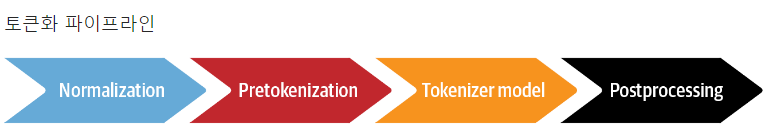

# 정규화
원시 문자열을 더 깨끗하게 만들기 위해 적용하는 일련의 연산  
공백과 악센트가 붙은 문자 제거하는 작업 등 문장에 쓸모없는 데이터를 제거하는 듯  
다양한 방식의 정규화가 있음 가장 일반적으로 유니코드 정규화 사용  

# 사전 토큰화  
텍스트를 더 작은 객체로 분할하며 훈련 마지막에 생성되는 토큰의 상한선을 제공 
텍스트를 단어로 분할, 최종 토큰은 이 단어의 일부가 됨  
영어,독일어,인도-유럽 언어는 문자열이 일반적으로 공백과 구두점을 기준으로 단어가 분활됨  
이렇게 분할된 단어들은 토크나이저를 사용하면 부분단어로 분할하기 쉬움
하지만 중국어,일본어,한국어 같은 언어에서 똑같은 방식을 사용하면 달라 질수 있음(한국어:아쉽다 -> 영어로는 한단어로 정의하는게 없음)  
언어별 사전 토큰화 라이브러리 사용하는게 좋을 수도 있음

# 토크나이저 모델 
앞의 과정을 거친 후 토크나이저를 사용해 부분 단어 분할 모델을 단어에 적용.
단어를 부분단어로 나눠 어휘사전의 크기와 OOV 토큰의 개수를 줄이는 역할
알고리즘에는 BPE,유니그램 WorldPiece 등이 존재
이 시점부터 문자열 리스트가 아니라 정수 idx를 가지게 됨

# 사후 처리  
토크나이저나 모델에 따라 특수 시퀀스를 추가해줌 
bert 스타일의 토크나이저는 CLS 와 SEP를 추가해 줌


In [7]:
"".join(xlmr_tokens).replace(u"\u2581", " ")
'''
SentencePiece 토크나이저는 유니그램 알고리즘 사용
부분단어 분할 방식을 기반으로 각 입력 텍스트를 유니코드 문자 시퀀스로 인코딩 -> 공백과 악센트를 몰라도 됨 큰 장점
고유한 특징은공백 문자가 u+2581 또는 _ 로 표현됨 그래서 복원하면 원본과 완전 똑같이 복구 가능
'''

'<s> Jack Sparrow loves New York!</s>'

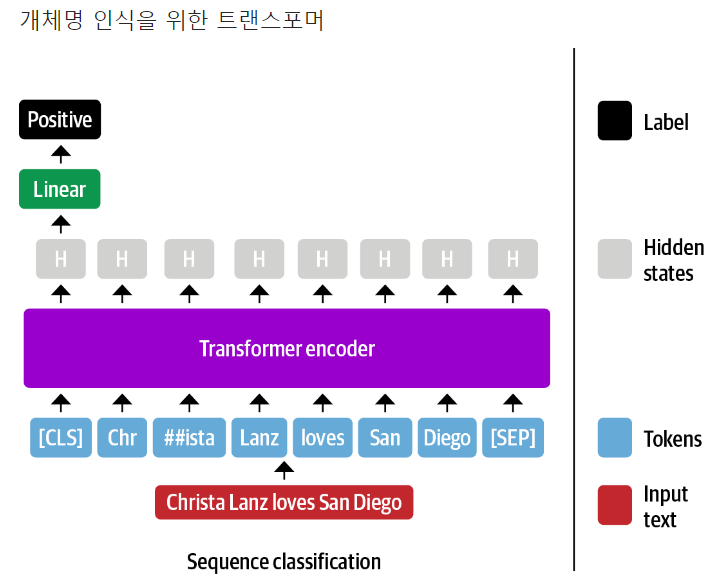

2장에서 구현했던 BERT를 이용한 NER   
CLS로 전체 텍스트 시퀀스를 표현함   
다른 인코더 기반 트랜스포머는 비슷비슷하게 사용함   
모든 입력 토큰의 표현이 NN층에 주입되어 해당 토큰의 개체명 인식 따라서 NER을 종종 토큰 분류 작업으로 생각함

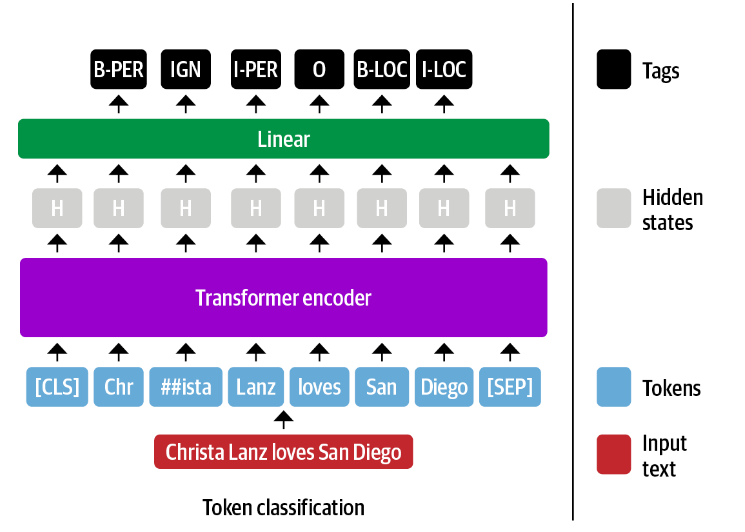

토큰 분류 작업에서 부분단어를 어떻게 처리할까?  
위 그림에서는 Christa는 Chr+##ista 로 토큰화 되버림 이중에 어느 단어에 B-PER레이블을 할당해야 될까?  
bert에서는 첫 번째 부분단어에 할당하고 이어지는 부분단어는 IGN으로 무시해버림  
이렇게 같은 규칙을 가지고 있는 토크나이저에 맞는 모델을 사용해버림